
Resultados para k-NN:


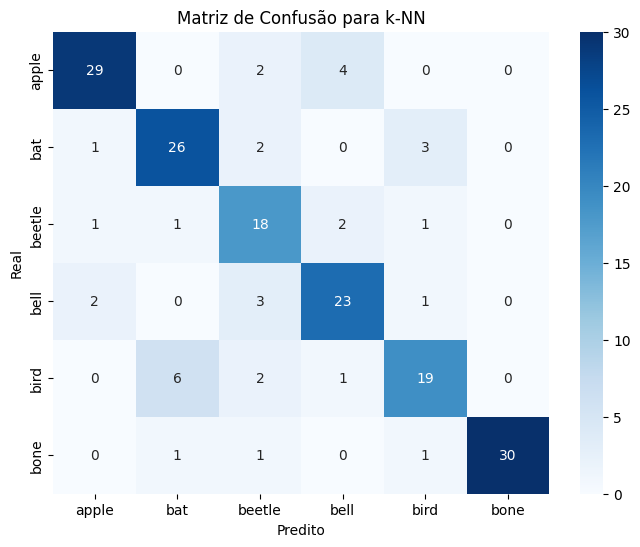

-------------------------------------------------------
Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.88      0.83      0.85        35
         bat       0.76      0.81      0.79        32
      beetle       0.64      0.78      0.71        23
        bell       0.77      0.79      0.78        29
        bird       0.76      0.68      0.72        28
        bone       1.00      0.91      0.95        33

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

-------------------------------------------------------
Acurácia de k-NN: 0.81

Resultados para SVM:


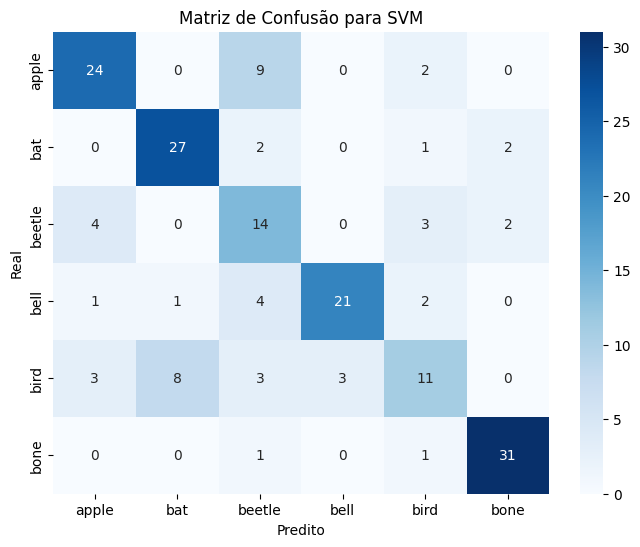

-------------------------------------------------------
Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.75      0.69      0.72        35
         bat       0.75      0.84      0.79        32
      beetle       0.42      0.61      0.50        23
        bell       0.88      0.72      0.79        29
        bird       0.55      0.39      0.46        28
        bone       0.89      0.94      0.91        33

    accuracy                           0.71       180
   macro avg       0.71      0.70      0.70       180
weighted avg       0.72      0.71      0.71       180

-------------------------------------------------------
Acurácia de SVM: 0.71

Resultados para RF:


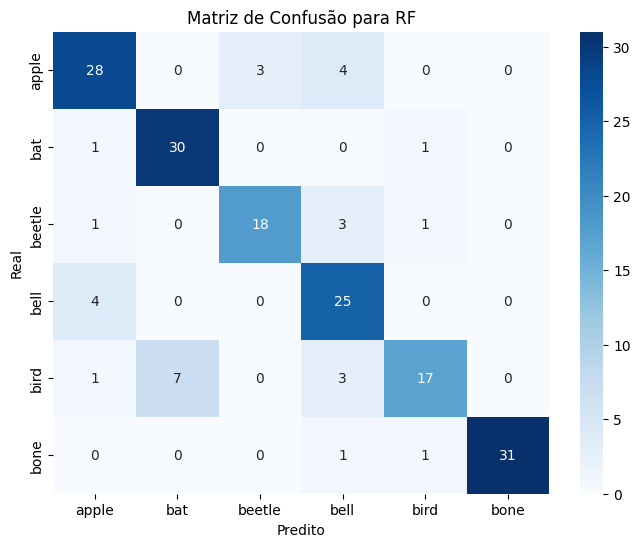

-------------------------------------------------------
Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.80      0.80      0.80        35
         bat       0.81      0.94      0.87        32
      beetle       0.86      0.78      0.82        23
        bell       0.69      0.86      0.77        29
        bird       0.85      0.61      0.71        28
        bone       1.00      0.94      0.97        33

    accuracy                           0.83       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.83      0.83       180

-------------------------------------------------------
Acurácia de RF: 0.83

Acurácia Média de todos os modelos: 0.78


In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


#função para extrair características morfológicas
def extract_features(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    return [area, perimeter, circularity]

#caminho para o dataset
dataset_path = '/content/drive/MyDrive/trabalho_visao/mpeg7_mod'

#carregando imagens e rótulos
data = []
labels = []
classes_list = os.listdir(dataset_path)

for classe in classes_list:
    classe_path = os.path.join(dataset_path, classe)
    for img_name in os.listdir(classe_path):
        img_path = os.path.join(classe_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)  #segmentação binária
        features = extract_features(binary)
        if features:
            data.append(features)
            labels.append(classe)

#convertendo para arrays numpy
data = np.array(data)
labels = np.array(labels)

#divisão do conjunto de dados (50% treino e 50% para validação e teste)
X_train, X_temp, y_train, y_temp = train_test_split(data,
                                                    labels,
                                                    test_size=0.5,
                                                    random_state=42)


#60% de 50% = 30% para teste, 40% de 50% = 20% para validação
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.6,
                                                random_state=42)

#normalização dos dados
scaler = StandardScaler() #faz com que os dados tenham média 0 e desvio padrão 1
X_train = scaler.fit_transform(X_train) #ajustando e transformando o conjunto de treinamento
X_val = scaler.transform(X_val) #apenas transformando (não ajustando)
X_test = scaler.transform(X_test) #apenas transformando (não ajustando)

#treinamento e teste do KNN (k-Nearest Neighbors)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#treinamento e teste do SVM (Support Vector Machine)
svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm.fit(X_train, y_train)

#treinamento e teste do RF (Random Forest Classifier)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#avaliação dos classificadores
accuracies = []

for name, model in [("k-NN", knn), ("SVM", svm), ("RF", rf)]:
    print(f"\nResultados para {name}:")

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    #tabela da Matriz de Confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Matriz de Confusão para {name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()


    print("-" * 55)
    print("Relatório de classificação:")
    print(classification_report(y_test, y_pred))
    print("-" * 55)

    #calcula a acurácia do modelo e armazenar na lista
    accuracy = np.mean(y_test == y_pred)
    accuracies.append(accuracy)
    print(f"Acurácia de {name}: {accuracy:.2f}")

#calcula acurácia média
average_accuracy = np.mean(accuracies)
print(f"\nAcurácia Média de todos os modelos: {average_accuracy:.2f}")